In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats import weightstats, oneway
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
df = pd.read_csv('Files/tracks_final.csv')

In [ ]:
df.sample(10)

In [ ]:
# Create separate dataframe for each cluster
cluster1 = df[df["Clusters"] == "Cluster 1"]
cluster2 = df[df["Clusters"] == "Cluster 2"]
cluster3 = df[df["Clusters"] == "Cluster 3"]
cluster4 = df[df["Clusters"] == "Cluster 4"]

### Funtions

In [ ]:
# Reveil the central tendencies of the data with info

def describe(df, feature):
    """
    Expects: Dataframe with all artists and the specific feature to describe
    Return: Dataframe with metrics on central tendencies
    """
    for i in range(1,5):
        cluster_name = f"Cluster {i}"
        cluster = df[df["Clusters"] == cluster_name][feature]
        
        # Calculate IQR
        q1 = cluster.quantile(0.25)
        q3 = cluster.quantile(0.75)
        iqr = q3 - q1
        df_describe = df[df["Clusters"] == cluster_name][[feature]].describe()
        df_describe = pd.pivot_table(df_describe, columns = list(df_describe.index)) 
        display(df_describe)
        print(f"The interquartile range (IQR) for {cluster_name} is {iqr}")
        
        # Variance
        variance = df[df["Clusters"] == cluster_name][feature].var()
        print(f"Variance is equal to {variance}")
        
        #Outliers
        out1 = q1 - iqr*1.5
        out3 = q3 + iqr*1.5
        outlier_sum = cluster[cluster < out1].count() + cluster[cluster > out3].count()
        outlier_percentage = round(((outlier_sum/cluster.count())*100),2)
        print(f"total number of outliers are {outlier_sum} which is {outlier_percentage}% of the cluster")
        print("")
        print("")

In [160]:
# Reveil the central tendencies of the data with plots.

def plot(df, feature):
    """
    Expects: Dataframe with all artists and the specific feature to describe
    Return: Histgram and box plots
    """
    order = ["Cluster 1","Cluster 2","Cluster 3","Cluster 4"]
    fig, axs = plt.subplots(ncols=2, figsize=(20,8))
    sns.histplot(df, x=feature, hue="Clusters", kde=True, hue_order=order, multiple="stack", ax=axs[0]);
    sns.boxplot(data=df, y=feature, x="Clusters", order=order, ax=axs[1]);
    fig.suptitle(f"{feature} Distribution Comparison", fontsize=16)
    # fig.savefig(f'Files/Plots/{feature} Comparison.png')

In [165]:
#Run anova and ad-hoc test to determine the difference in feature between clusters
def anova(feature, sample_size):
    """
    Expects: Feature to describe and sample size
    Return: Result for anova test comparing all the clusters and the Tuckey's HSD to confirm similarities/dissimilarities
    """
    c1 = cluster1[feature].sample(n=sample_size, random_state=876).tolist()
    c2 = cluster2[feature].sample(n=sample_size, random_state=876).tolist()
    c3 = cluster3[feature].sample(n=sample_size, random_state=876).tolist()
    c4 = cluster4[feature].sample(n=sample_size, random_state=876).tolist()

    df = pd.concat([
        pd.DataFrame(data={feature:c1, "Cluster":"Cluster 1"}),
        pd.DataFrame(data={feature:c2, "Cluster":"Cluster 2"}),
        pd.DataFrame(data={feature:c3, "Cluster":"Cluster 3"}),
        pd.DataFrame(data={feature:c4, "Cluster":"Cluster 4"})
    ])

    print(stats.f_oneway(c1, c2, c3, c4))
    print("______________________________________________________________")
    print(oneway.anova_oneway((c1, c2, c3, c4)))
    print("______________________________________________________________")
    results = pairwise_tukeyhsd(endog=df[feature], groups=df["Cluster"], alpha=0.05)
    print(results)

In [162]:
# Compare the differences in features among clusters
def ratings(feature, sample_size):
    """
    Expects: Feature to describe and sample size
    Return: Bar graphs showing the features per cluster
    """
    c1 = cluster1[feature].sample(n=sample_size, random_state=876).mean()
    c2 = cluster2[feature].sample(n=sample_size, random_state=876).mean()
    c3 = cluster3[feature].sample(n=sample_size, random_state=876).mean()
    c4 = cluster4[feature].sample(n=sample_size, random_state=876).mean()
    
    ratings = {"means":[c1,c2,c3,c4],
           "clusters":["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]
          }
    df = pd.DataFrame(ratings)
    
    sns.barplot(data=df, y="clusters" , x="means");
    plt.title(f"{feature} Means Comparison", fontsize=16)
    # plt.savefig(f'Files/Plots/{feature} Cluster-Ratings.png')

In [163]:
# Side by display of clusters and all their features
def compare(df, sample_size):
    """
    Expects: Parent dataframe and sample size
    Return: Bar graphs showing the all features for all the clusters
    """
    features = df.columns[4:12].tolist()
    features.pop(2)
    c1 = cluster1[features].sample(sample_size, random_state=876).mean()
    c2 = cluster2[features].sample(sample_size, random_state=876).mean()
    c3 = cluster3[features].sample(sample_size, random_state=876).mean()
    c4 = cluster4[features].sample(sample_size, random_state=876).mean()
    
    compare = pd.concat([
        pd.DataFrame(c1, columns=["Cluster 1"]),
        pd.DataFrame(c2, columns=["Cluster 2"]),
        pd.DataFrame(c3, columns=["Cluster 3"]),
        pd.DataFrame(c4, columns=["Cluster 4"])
    ], axis=1)
    
    fig, axs = plt.subplots(ncols=4, figsize=(30,8))
    plt.setp(axs, xlim=(0, 0.9))
    sns.barplot(data=compare[["Cluster 1"]], x="Cluster 1", y=compare.index, ax=axs[0]);
    sns.barplot(data=compare[["Cluster 2"]], x="Cluster 2", y=compare.index, ax=axs[1]);
    sns.barplot(data=compare[["Cluster 3"]], x="Cluster 3", y=compare.index, ax=axs[2]);
    sns.barplot(data=compare[["Cluster 4"]], x="Cluster 4", y=compare.index, ax=axs[3]);
    plt.grid(True)
    # plt.savefig('Files/Plots/Cluster Comparison.png')
    
    
    

In [164]:
# Create dataframe for each recomendation
def recommendations(track_info):
    """
    Expects: The json file for tracks returned from spotiy api
    Return: Dataframe with all tracks and there features
    """ 
    recommendations = {"Artist":[], "Name":[], "Link":[], "Danceability":[], "Energy":[], "Speechiness":[], "Acousticness":[], "Liveness":[], "Valence":[]}
    sample_len = len(track_info)
    for i in range(sample_len):
        name = track_info[i]['name']
        link = track_info[i]['external_urls']['spotify']
        artist = track_info[i]["album"]["artists"][0]["name"]
        recommendations["Name"].append(name)
        recommendations["Link"].append(link)
        recommendations["Artist"].append(artist)
        track_id = track_info[i]["id"]
        track_features = sp.audio_features(track_id)[0]
        recommendations["Danceability"].append(track_features["danceability"])
        recommendations["Energy"].append(track_features["energy"])
        recommendations["Speechiness"].append(track_features["speechiness"])
        recommendations["Acousticness"].append(track_features["acousticness"])
        recommendations["Liveness"].append(track_features["liveness"])
        recommendations["Valence"].append(track_features["valence"])  
    return pd.DataFrame(recommendations)

In [ ]:
# Compare recommendation sample with cluster sample
def compare2(df,df2, features):
    """
    Expects: Two dataframes that require comparison and the list of features
    Return: Bar graph comparing both samples and p-values for t-test comparisons
    """ 
    c1 = df[features].sample(20, random_state=876).mean()
    c2 = df2[features].mean()
    compare = pd.concat([
        pd.DataFrame(c1, columns=["Cluster"]),
        pd.DataFrame(c2, columns=["Recommendation"]),
    ], axis=1)
    # display(compare)
    
    fig, axs = plt.subplots(ncols=2, figsize=(20,8))
    plt.setp(axs, xlim=(0, 0.9))
    sns.barplot(data=compare[["Cluster"]], x="Cluster", y=compare.index, ax=axs[0]);
    sns.barplot(data=compare[["Recommendation"]], x="Recommendation", y=compare.index, ax=axs[1]);
    # fig.savefig('Files/Cluster-Recommendation-Comparison.png')
    
    df_compare = compare.reset_index()
    df_compare2 = pd.pivot_table(df_compare, columns="index").reset_index()
    
    fig2, axs2 = plt.subplots(ncols=6, figsize=(30,8))
    plt.setp(axs2, ylim=(0, 1))
    sns.barplot(data=df_compare2, y="Danceability", x="index", ax=axs2[0]);
    sns.barplot(data=df_compare2, y="Energy", x="index", ax=axs2[1]);
    sns.barplot(data=df_compare2, y="Speechiness", x="index", ax=axs2[2]);
    sns.barplot(data=df_compare2, y="Acousticness", x="index", ax=axs2[3]);
    sns.barplot(data=df_compare2, y="Liveness", x="index", ax=axs2[4]);
    sns.barplot(data=df_compare2, y="Valence", x="index", ax=axs2[5]);
    plt.show()
    # fig2.savefig('Files/Cluster-Recommendation-Comparison2.png')
    
    # Run t-test to determine the differences
    for feature in features:
        result = stats.ttest_ind(df2[feature], df[feature].sample(100, random_state=876), equal_var=False)
        ci = 0.05
        if result[1] > ci:
            print(f"P-value = {result[1]} - similar {feature}")
        else:
            print(f"P-value = {result[1]} - dissimilar {feature}")

### Popularity

In [ ]:
plot(df, "Danceability")

In [ ]:
describe(df, "Popularity")

Popularity: popularity in the most part, is based on the total number of plays the track has had and how recent those plays are. Songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past.

In [156]:
cluster1[cluster1["Popularity"] > 30]["Popularity"].count()

800

In [157]:
cluster2[cluster2["Popularity"] > 30]["Popularity"].count()

223

In [158]:
cluster3[cluster3["Popularity"] > 30]["Popularity"].count()

637

In [159]:
cluster4[cluster4["Popularity"] > 30]["Popularity"].count()

150

### Danceability

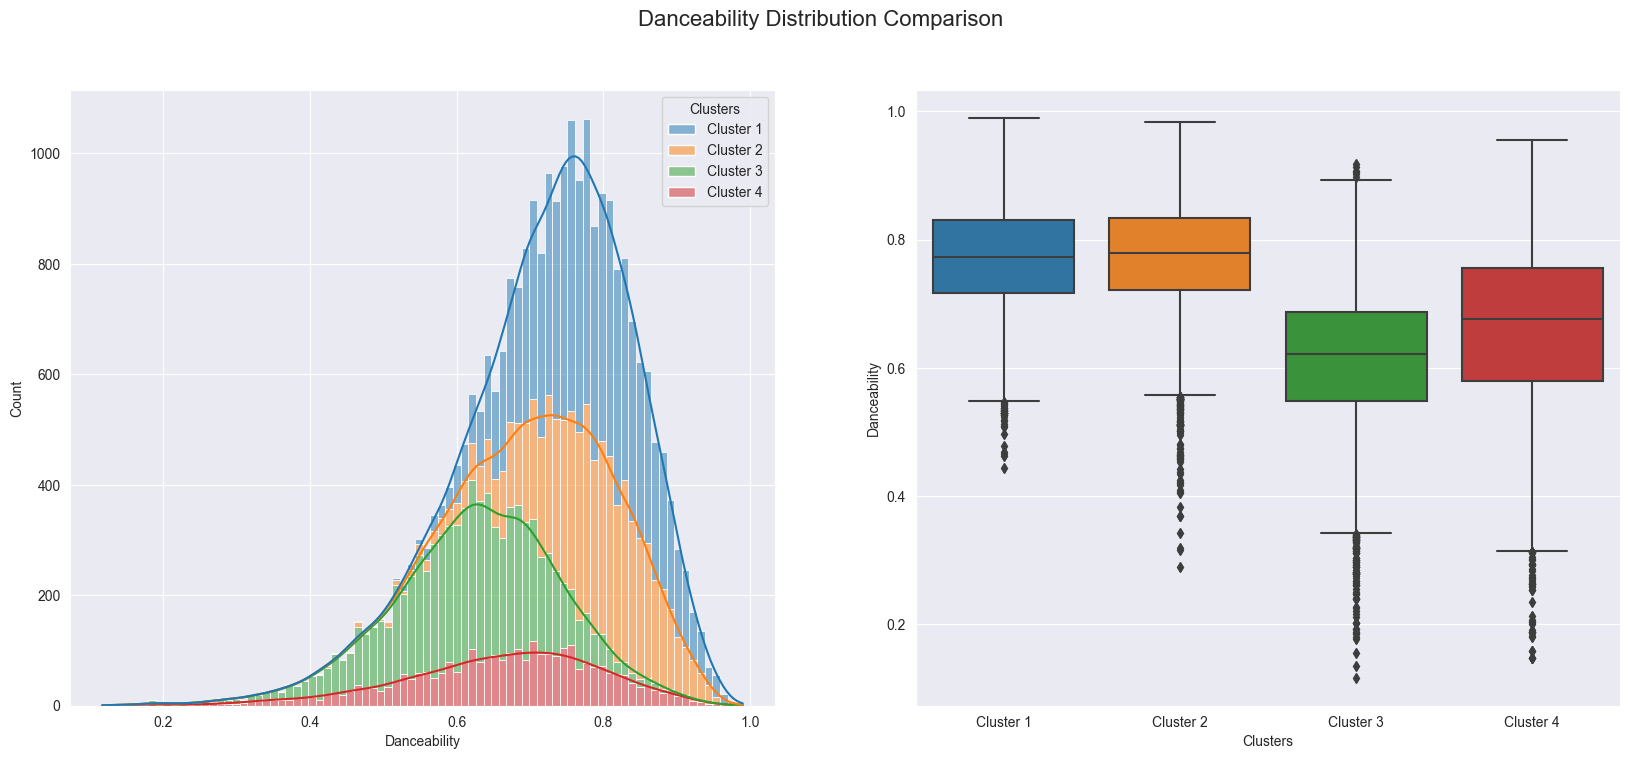

In [122]:
plot(df, "Danceability")

In [121]:
describe(df, "Danceability")

,25%,50%,75%,count,max,mean,min,std
Danceability,0.717,0.773,0.83,9693.0,0.99,0.771821,0.444,0.080702


The interquartile range (IQR) for Cluster 1 is 0.11299999999999999
Variance is equal to 0.006512864263662069
total number of outliers are 33 which is 0.34% of the cluster




,25%,50%,75%,count,max,mean,min,std
Danceability,0.722,0.779,0.833,6819.0,0.983,0.772854,0.29,0.084945


The interquartile range (IQR) for Cluster 2 is 0.11099999999999999
Variance is equal to 0.007215641301970136
total number of outliers are 97 which is 1.42% of the cluster




,25%,50%,75%,count,max,mean,min,std
Danceability,0.549,0.621,0.687,6807.0,0.918,0.613515,0.117,0.106334


The interquartile range (IQR) for Cluster 3 is 0.138
Variance is equal to 0.011306850447506955
total number of outliers are 98 which is 1.44% of the cluster




,25%,50%,75%,count,max,mean,min,std
Danceability,0.579,0.676,0.756,3051.0,0.956,0.660024,0.148,0.136364


The interquartile range (IQR) for Cluster 4 is 0.17700000000000005
Variance is equal to 0.018595024673232638
total number of outliers are 44 which is 1.44% of the cluster




In [155]:
anova("Danceability", 100)

F_onewayResult(statistic=55.006020415707205, pvalue=9.654135274922579e-30)
______________________________________________________________
statistic = 56.33703298768513
pvalue = 6.799115096328874e-27
df = (3.0, 214.39023941525184)
df_num = 3.0
df_denom = 214.39023941525184
nobs_t = 400.0
n_groups = 4
means = [0.76631 0.77144 0.6134  0.66277]
nobs = [100. 100. 100. 100.]
vars_ = [0.00622141 0.00534712 0.01465749 0.01822458]
use_var = unequal
welch_correction = True
tuple = (56.33703298768513, 6.799115096328874e-27)
______________________________________________________________
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
Cluster 1 Cluster 2   0.0051  0.986 -0.0333  0.0436  False
Cluster 1 Cluster 3  -0.1529    0.0 -0.1914 -0.1144   True
Cluster 1 Cluster 4  -0.1035    0.0  -0.142 -0.0651   True
Cluster 2 Cluster 3   -0.158    0.0 -0.1965 -0.1196   True
Clust

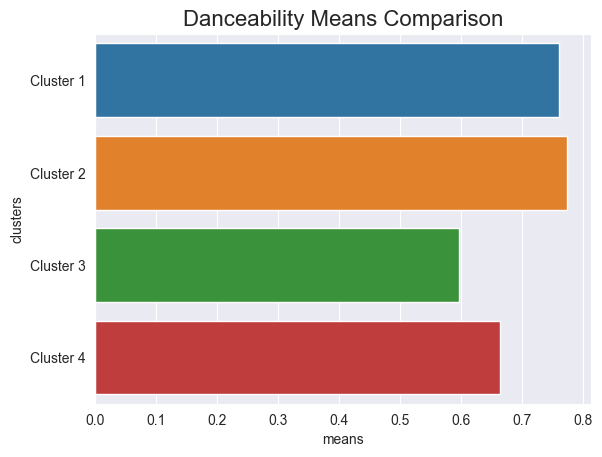

In [123]:
ratings("Danceability", 100)

### Energy

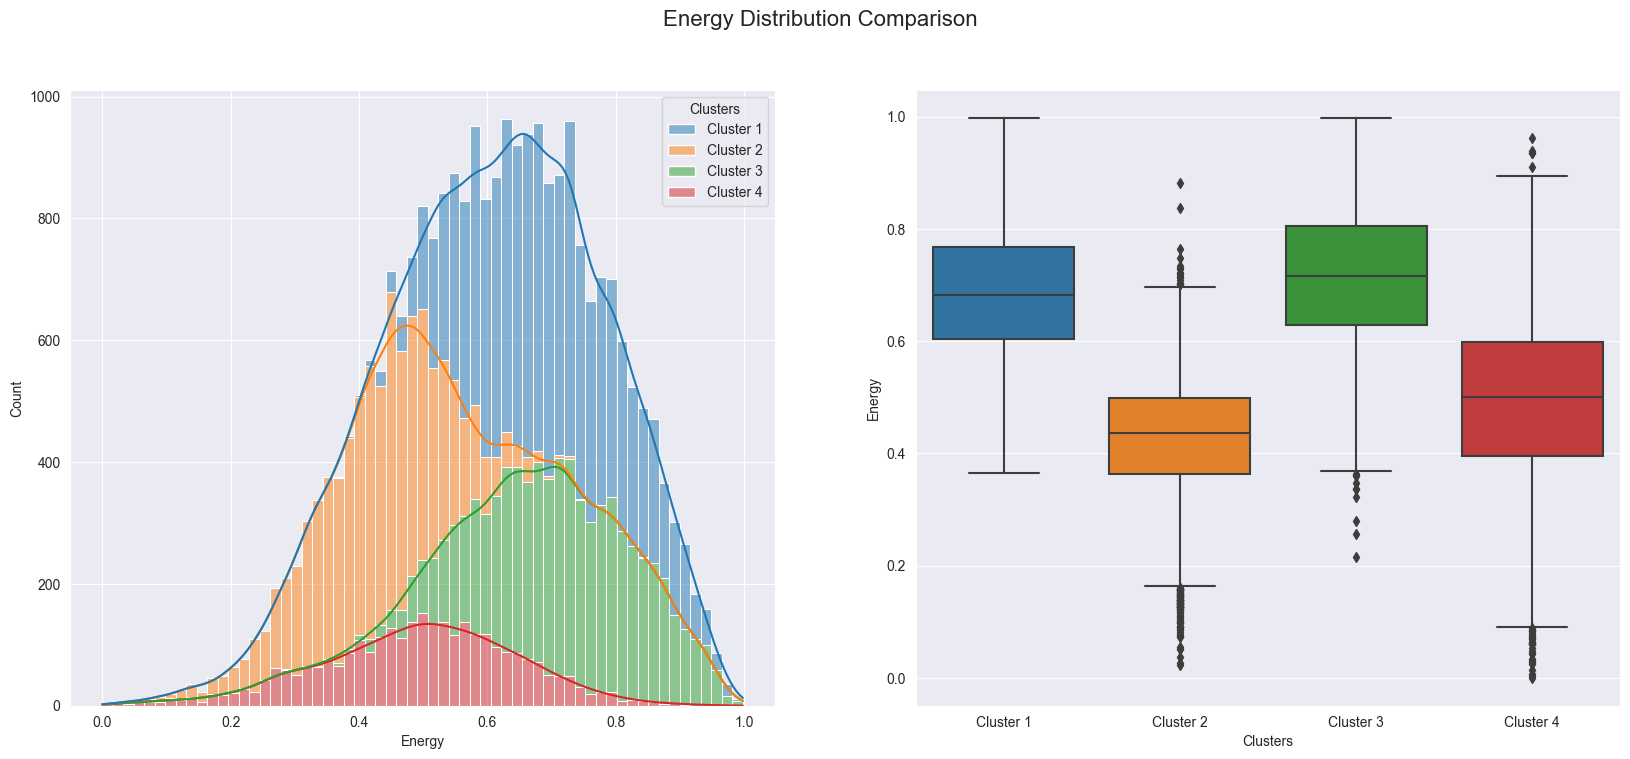

In [124]:
plot(df, "Energy")

In [ ]:
describe(df, "Energy")

In [126]:
anova("Energy", 100)

F_onewayResult(statistic=134.00744899539944, pvalue=6.287291216755563e-60)
______________________________________________________________
statistic = 153.99358869071352
pvalue = 1.3388342109398775e-53
df = (3.0, 218.1270218880265)
df_num = 3.0
df_denom = 218.1270218880265
nobs_t = 400.0
n_groups = 4
means = [0.66552  0.42346  0.71871  0.469027]
nobs = [100. 100. 100. 100.]
vars_ = [0.01406843 0.01026777 0.01490782 0.02334509]
use_var = unequal
welch_correction = True
tuple = (153.99358869071352, 1.3388342109398775e-53)
______________________________________________________________
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
Cluster 1 Cluster 2  -0.2421    0.0 -0.2877 -0.1964   True
Cluster 1 Cluster 3   0.0532 0.0149  0.0075  0.0988   True
Cluster 1 Cluster 4  -0.1965    0.0 -0.2421 -0.1509   True
Cluster 2 Cluster 3   0.2952    0.0  0.2496  0.3409   True

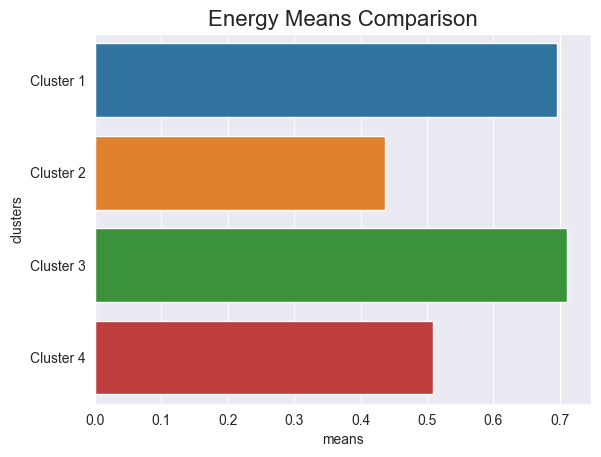

In [127]:
ratings("Energy", 100)

### Loudness

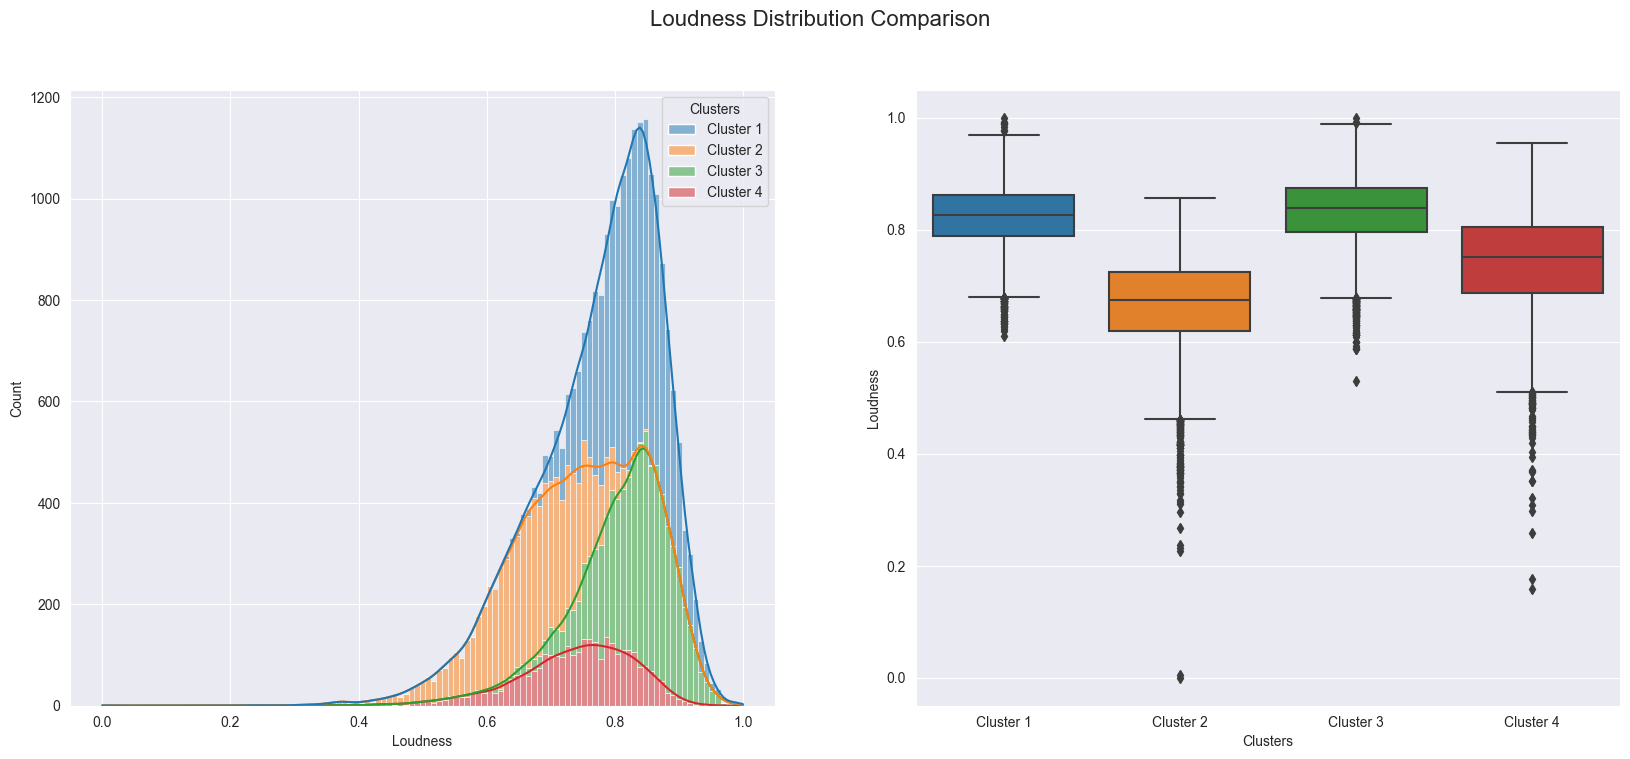

In [128]:
plot(df, "Loudness")

In [129]:
describe(df, "Loudness")

,25%,50%,75%,count,max,mean,min,std
Loudness,0.788352,0.827085,0.86127,9693.0,1.0,0.823263,0.610217,0.054171


The interquartile range (IQR) for Cluster 1 is 0.07291801245445861
Variance is equal to 0.0029345410160310464
total number of outliers are 79 which is 0.82% of the cluster




,25%,50%,75%,count,max,mean,min,std
Loudness,0.619506,0.673652,0.724955,6819.0,0.857446,0.665885,0.0,0.081835


The interquartile range (IQR) for Cluster 2 is 0.10544947158988138
Variance is equal to 0.006696946421931253
total number of outliers are 126 which is 1.85% of the cluster




,25%,50%,75%,count,max,mean,min,std
Loudness,0.795561,0.83848,0.873711,6807.0,0.999406,0.83189,0.529625,0.059887


The interquartile range (IQR) for Cluster 3 is 0.07815043538926647
Variance is equal to 0.0035863967845022743
total number of outliers are 115 which is 1.69% of the cluster




,25%,50%,75%,count,max,mean,min,std
Loudness,0.687825,0.750446,0.805741,3051.0,0.954136,0.738531,0.158471,0.093355


The interquartile range (IQR) for Cluster 4 is 0.11791684969380634
Variance is equal to 0.008715202634316858
total number of outliers are 63 which is 2.06% of the cluster




In [130]:
anova("Loudness", 100)

F_onewayResult(statistic=112.79747291532212, pvalue=8.404127011828165e-53)
______________________________________________________________
statistic = 141.41742294530619
pvalue = 1.1366623104259834e-50
df = (3.0, 215.5821448227362)
df_num = 3.0
df_denom = 215.5821448227362
nobs_t = 400.0
n_groups = 4
means = [0.81520167 0.67894964 0.83525981 0.74124725]
nobs = [100. 100. 100. 100.]
vars_ = [0.00222098 0.00370216 0.00393263 0.00834452]
use_var = unequal
welch_correction = True
tuple = (141.41742294530619, 1.1366623104259834e-50)
______________________________________________________________
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj  lower   upper  reject
---------------------------------------------------------
Cluster 1 Cluster 2  -0.1363   0.0 -0.1609 -0.1116   True
Cluster 1 Cluster 3   0.0201 0.154 -0.0046  0.0447  False
Cluster 1 Cluster 4   -0.074   0.0 -0.0986 -0.0493   True
Cluster 2 Cluster 3   0.1563   0.0  0.1317  0.1809   Tru

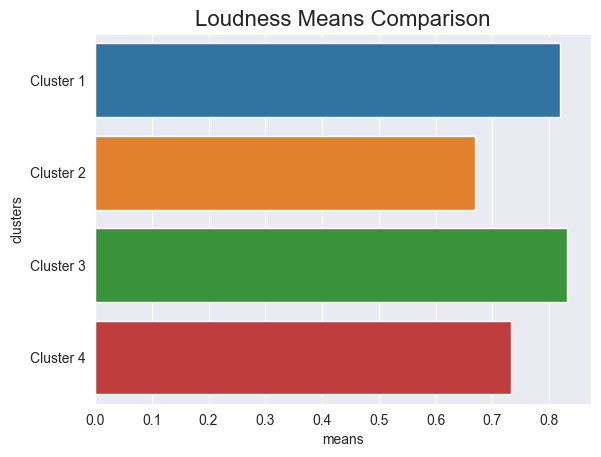

In [131]:
ratings("Loudness", 100)

### Speechiness

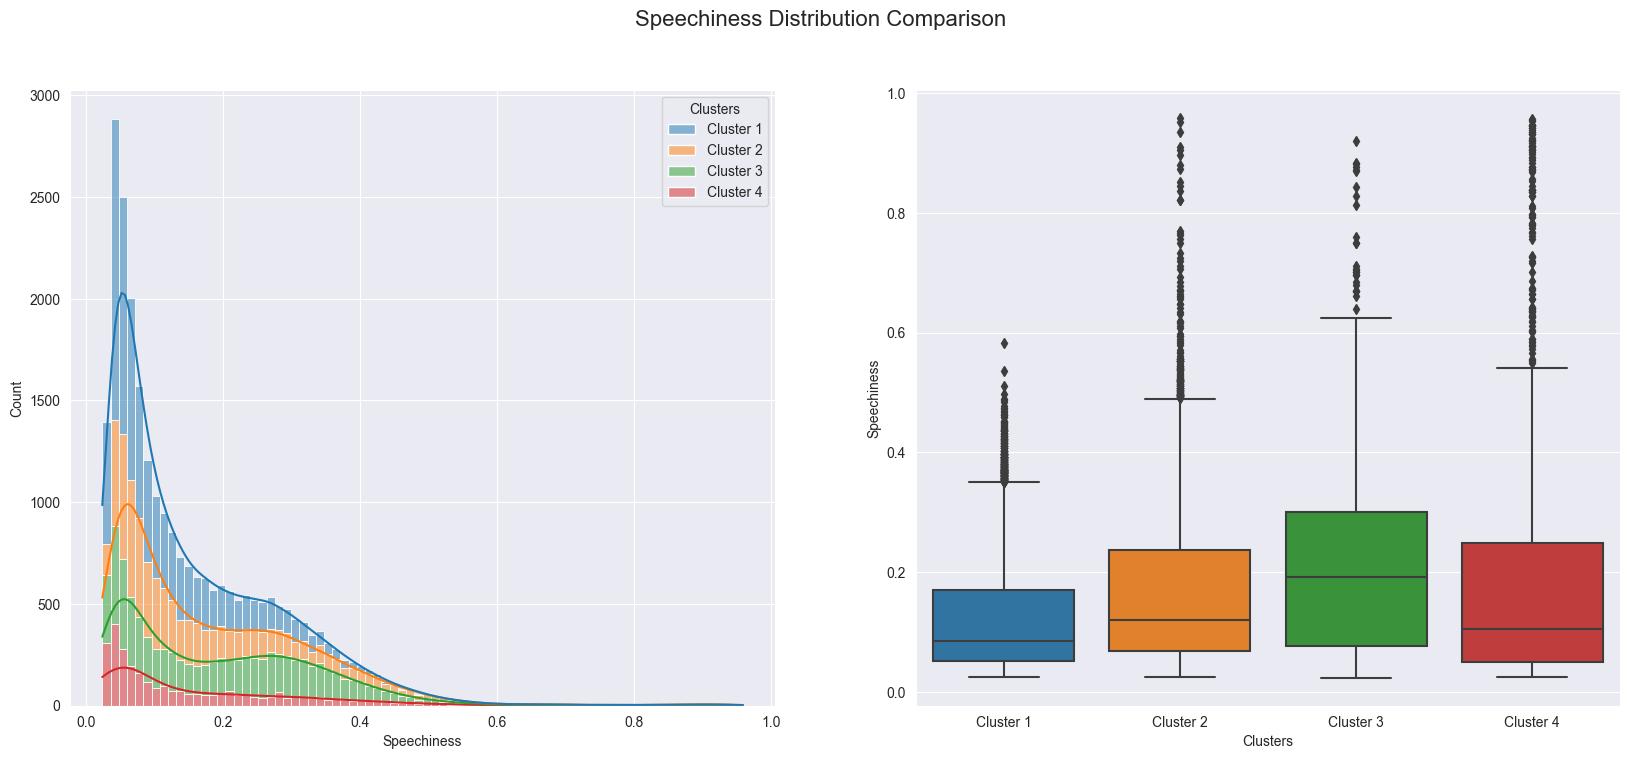

In [132]:
plot(df, "Speechiness")

In [133]:
describe(df, "Speechiness")

,25%,50%,75%,count,max,mean,min,std
Speechiness,0.0511,0.085,0.171,9693.0,0.583,0.121744,0.0244,0.091757


The interquartile range (IQR) for Cluster 1 is 0.1199
Variance is equal to 0.008419290487563113
total number of outliers are 244 which is 2.52% of the cluster




,25%,50%,75%,count,max,mean,min,std
Speechiness,0.06825,0.121,0.237,6819.0,0.959,0.167091,0.0243,0.128379


The interquartile range (IQR) for Cluster 2 is 0.16874999999999998
Variance is equal to 0.01648123805794647
total number of outliers are 141 which is 2.07% of the cluster




,25%,50%,75%,count,max,mean,min,std
Speechiness,0.07625,0.192,0.301,6807.0,0.92,0.202234,0.0238,0.133805


The interquartile range (IQR) for Cluster 3 is 0.22474999999999998
Variance is equal to 0.017903842294894355
total number of outliers are 26 which is 0.38% of the cluster




,25%,50%,75%,count,max,mean,min,std
Speechiness,0.0496,0.105,0.248,3051.0,0.957,0.172977,0.0246,0.17104


The interquartile range (IQR) for Cluster 4 is 0.1984
Variance is equal to 0.029254545677721358
total number of outliers are 108 which is 3.54% of the cluster




In [134]:
anova("Speechiness", 100)

F_onewayResult(statistic=8.254107565032257, pvalue=2.4397372447332504e-05)
______________________________________________________________
statistic = 13.90433267504739
pvalue = 2.5993937685238058e-08
df = (3.0, 212.31134049313357)
df_num = 3.0
df_denom = 212.31134049313357
nobs_t = 400.0
n_groups = 4
means = [0.108798 0.174932 0.188687 0.18147 ]
nobs = [100. 100. 100. 100.]
vars_ = [0.00657748 0.019211   0.01605588 0.0240671 ]
use_var = unequal
welch_correction = True
tuple = (13.90433267504739, 2.5993937685238058e-08)
______________________________________________________________
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
Cluster 1 Cluster 2   0.0661 0.0017  0.0193  0.113   True
Cluster 1 Cluster 3   0.0799 0.0001  0.0331 0.1267   True
Cluster 1 Cluster 4   0.0727 0.0004  0.0258 0.1195   True
Cluster 2 Cluster 3   0.0138 0.8733 -0.0331 0.0606  False
Cluste

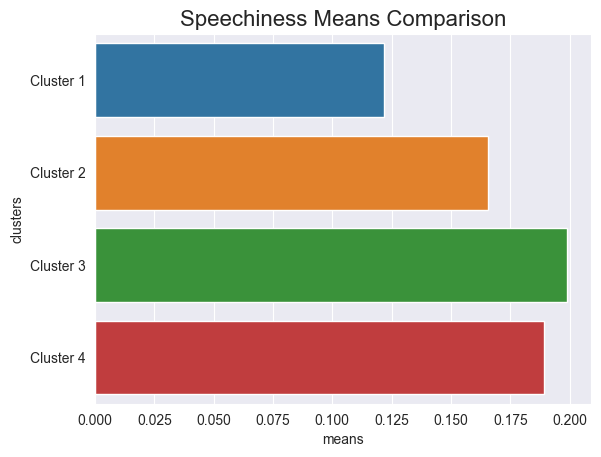

In [135]:
ratings("Speechiness", 100)

### Liveness

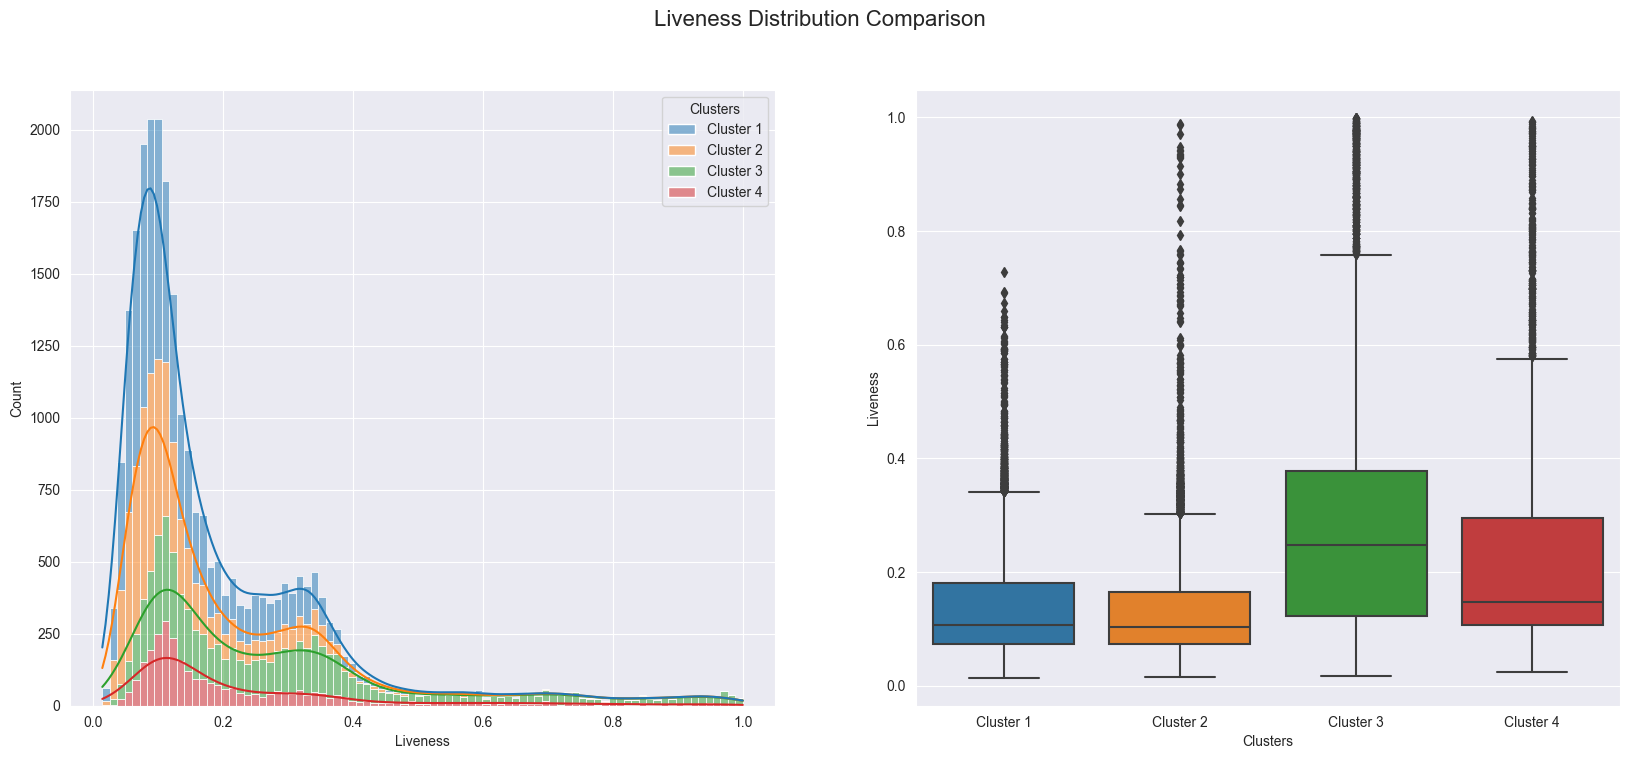

In [136]:
plot(df, "Liveness")

In [137]:
describe(df, "Liveness")

,25%,50%,75%,count,max,mean,min,std
Liveness,0.074,0.106,0.181,9693.0,0.728,0.142013,0.0139,0.098243


The interquartile range (IQR) for Cluster 1 is 0.107
Variance is equal to 0.009651672883032201
total number of outliers are 482 which is 4.97% of the cluster




,25%,50%,75%,count,max,mean,min,std
Liveness,0.0731,0.103,0.165,6819.0,0.988,0.140098,0.0149,0.109792


The interquartile range (IQR) for Cluster 2 is 0.09190000000000001
Variance is equal to 0.012054237613758532
total number of outliers are 661 which is 9.69% of the cluster




,25%,50%,75%,count,max,mean,min,std
Liveness,0.123,0.248,0.377,6807.0,0.999,0.305003,0.017,0.231546


The interquartile range (IQR) for Cluster 3 is 0.254
Variance is equal to 0.053613388476580766
total number of outliers are 483 which is 7.1% of the cluster




,25%,50%,75%,count,max,mean,min,std
Liveness,0.106,0.147,0.2945,3051.0,0.993,0.229964,0.0242,0.19491


The interquartile range (IQR) for Cluster 4 is 0.1885
Variance is equal to 0.03798991994663399
total number of outliers are 255 which is 8.36% of the cluster




In [138]:
anova("Liveness", 100)

F_onewayResult(statistic=30.5177497464038, pvalue=9.085732459815014e-18)
______________________________________________________________
statistic = 19.429476891849028
pvalue = 3.5614796513207884e-11
df = (3.0, 213.22987542692798)
df_num = 3.0
df_denom = 213.22987542692798
nobs_t = 400.0
n_groups = 4
means = [0.133192 0.141995 0.316762 0.187764]
nobs = [100. 100. 100. 100.]
vars_ = [0.00836482 0.01065008 0.05754374 0.01741109]
use_var = unequal
welch_correction = True
tuple = (19.429476891849028, 3.5614796513207884e-11)
______________________________________________________________
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
Cluster 1 Cluster 2   0.0088 0.9773 -0.0471  0.0647  False
Cluster 1 Cluster 3   0.1836    0.0  0.1276  0.2395   True
Cluster 1 Cluster 4   0.0546 0.0587 -0.0014  0.1105  False
Cluster 2 Cluster 3   0.1748    0.0  0.1188  0.2307   True

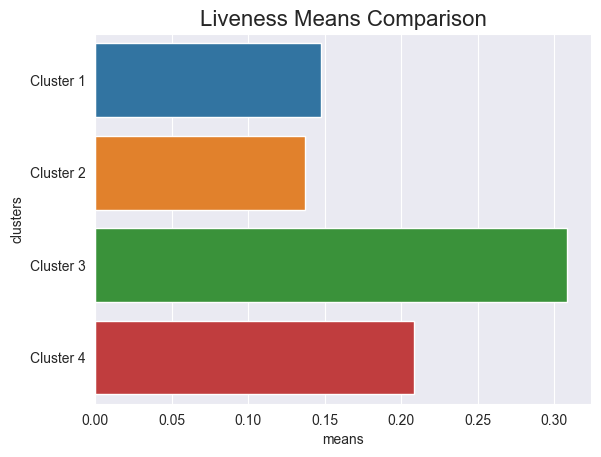

In [139]:
ratings("Liveness", 100)

### Valence

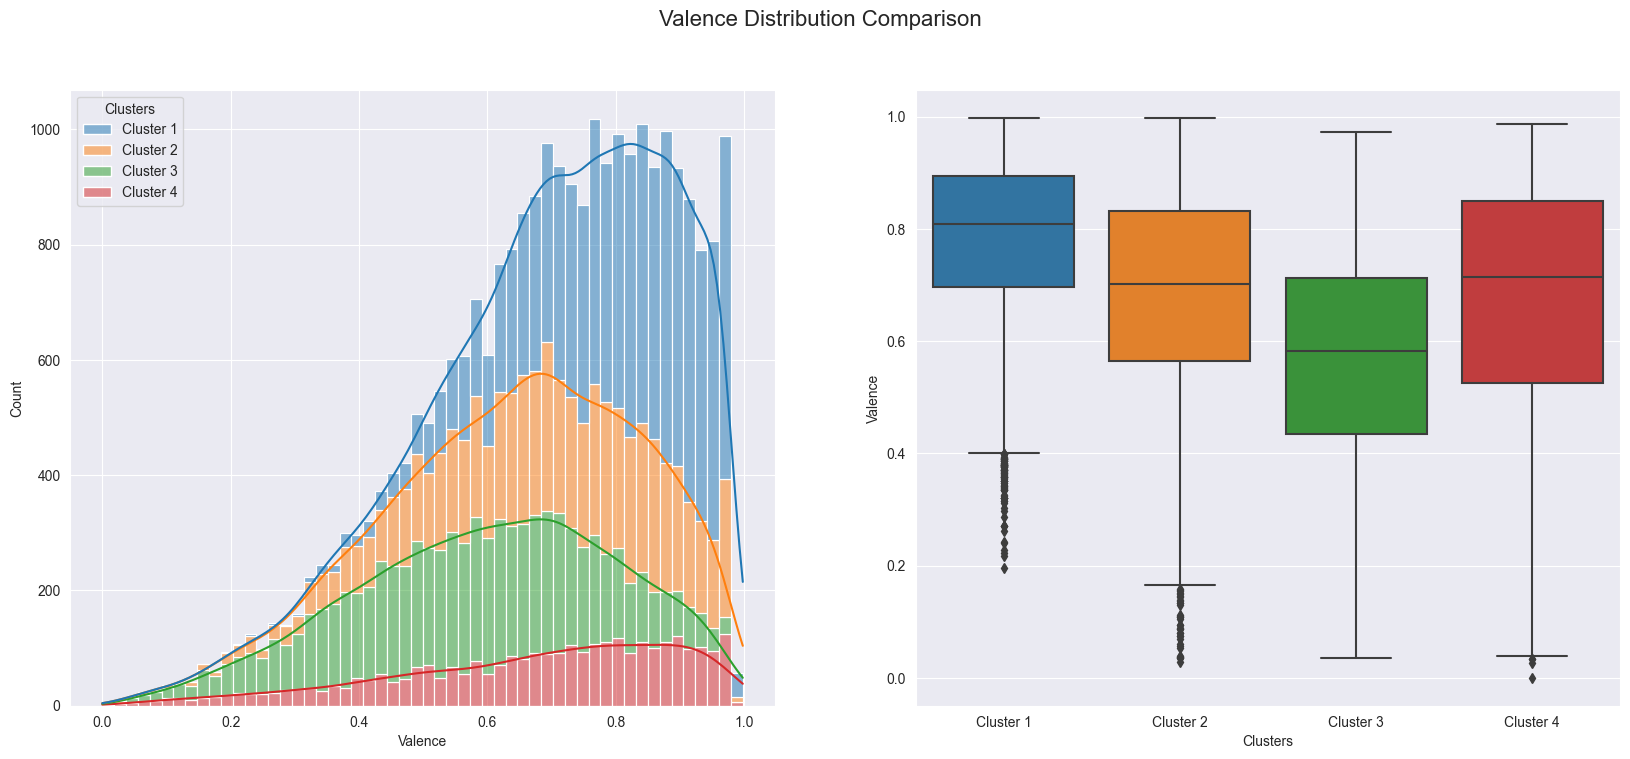

In [140]:
plot(df, "Valence")

In [141]:
describe(df, "Valence")

,25%,50%,75%,count,max,mean,min,std
Valence,0.697,0.808,0.895,9693.0,0.997,0.786151,0.195,0.136231


The interquartile range (IQR) for Cluster 1 is 0.19800000000000006
Variance is equal to 0.018558944509291204
total number of outliers are 84 which is 0.87% of the cluster




,25%,50%,75%,count,max,mean,min,std
Valence,0.5645,0.702,0.832,6819.0,0.998,0.685909,0.0285,0.183351


The interquartile range (IQR) for Cluster 2 is 0.26749999999999996
Variance is equal to 0.03361757335791265
total number of outliers are 36 which is 0.53% of the cluster




,25%,50%,75%,count,max,mean,min,std
Valence,0.435,0.582,0.713,6807.0,0.973,0.570063,0.0348,0.192191


The interquartile range (IQR) for Cluster 3 is 0.27799999999999997
Variance is equal to 0.03693720063252505
total number of outliers are 0 which is 0.0% of the cluster




,25%,50%,75%,count,max,mean,min,std
Valence,0.5255,0.714,0.85,3051.0,0.986,0.672161,0.00001,0.219299


The interquartile range (IQR) for Cluster 4 is 0.3244999999999999
Variance is equal to 0.04809208565096754
total number of outliers are 4 which is 0.13% of the cluster




In [142]:
anova("Valence", 100)

F_onewayResult(statistic=32.377520024038525, pvalue=9.77305379908137e-19)
______________________________________________________________
statistic = 48.30273828068667
pvalue = 6.88600378685162e-24
df = (3.0, 214.32011494110768)
df_num = 3.0
df_denom = 214.32011494110768
nobs_t = 400.0
n_groups = 4
means = [0.81288 0.6882  0.57467 0.63155]
nobs = [100. 100. 100. 100.]
vars_ = [0.01440093 0.0308056  0.03096859 0.05200362]
use_var = unequal
welch_correction = True
tuple = (48.30273828068667, 6.88600378685162e-24)
______________________________________________________________
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
Cluster 1 Cluster 2  -0.1247    0.0   -0.19 -0.0594   True
Cluster 1 Cluster 3  -0.2382    0.0 -0.3035 -0.1729   True
Cluster 1 Cluster 4  -0.1813    0.0 -0.2466  -0.116   True
Cluster 2 Cluster 3  -0.1135 0.0001 -0.1788 -0.0482   True
Cluster 

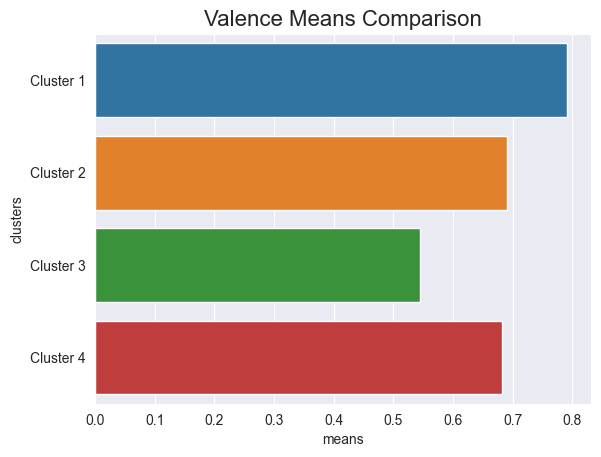

In [143]:
ratings("Valence", 100)

### Acousticness

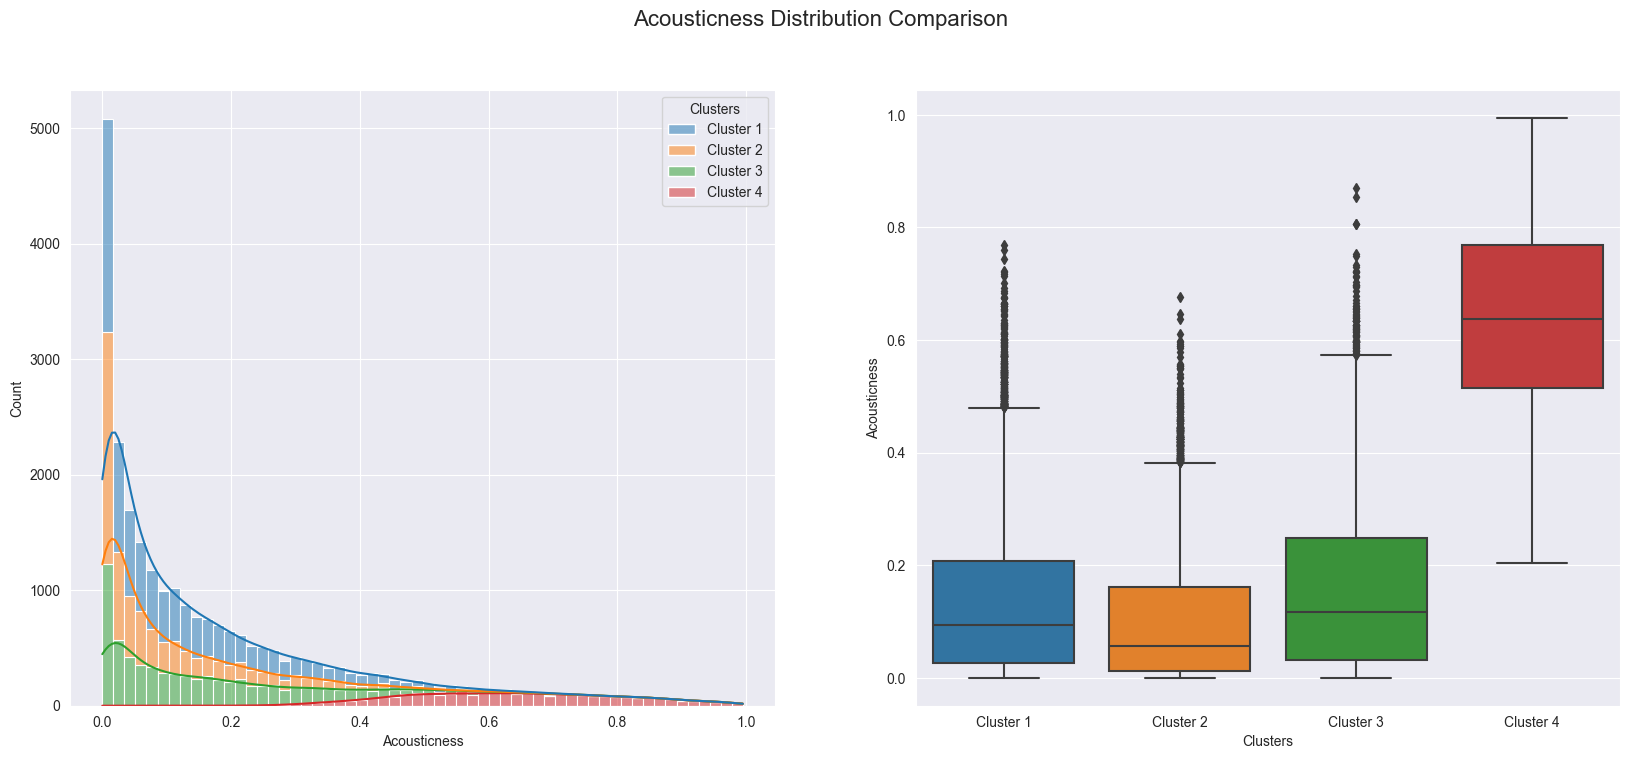

In [148]:
plot(df, "Acousticness")

In [149]:
describe(df, "Acousticness")

,25%,50%,75%,count,max,mean,min,std
Acousticness,0.0264,0.0937,0.208,9693.0,0.768,0.138047,0.000005,0.138086


The interquartile range (IQR) for Cluster 1 is 0.18159999999999998
Variance is equal to 0.019067839650711193
total number of outliers are 265 which is 2.73% of the cluster




,25%,50%,75%,count,max,mean,min,std
Acousticness,0.0124,0.0557,0.161,6819.0,0.677,0.103662,0.00001,0.11794


The interquartile range (IQR) for Cluster 2 is 0.1486
Variance is equal to 0.013909825297211076
total number of outliers are 239 which is 3.5% of the cluster




,25%,50%,75%,count,max,mean,min,std
Acousticness,0.0309,0.116,0.248,6807.0,0.871,0.157754,0.000003,0.14873


The interquartile range (IQR) for Cluster 3 is 0.2171
Variance is equal to 0.02212073283122859
total number of outliers are 80 which is 1.18% of the cluster




,25%,50%,75%,count,max,mean,min,std
Acousticness,0.514,0.637,0.768,3051.0,0.995,0.642984,0.203,0.164589


The interquartile range (IQR) for Cluster 4 is 0.254
Variance is equal to 0.027089623676408166
total number of outliers are 0 which is 0.0% of the cluster




In [150]:
anova("Acousticness", 100)

F_onewayResult(statistic=278.02266547810484, pvalue=4.523174253009762e-97)
______________________________________________________________
statistic = 268.76726639900284
pvalue = 7.624295214190313e-73
df = (3.0, 217.35636278473314)
df_num = 3.0
df_denom = 217.35636278473314
nobs_t = 400.0
n_groups = 4
means = [0.14234823 0.09917348 0.173261   0.61951   ]
nobs = [100. 100. 100. 100.]
vars_ = [0.02214416 0.01240079 0.02586054 0.02422553]
use_var = unequal
welch_correction = True
tuple = (268.76726639900284, 7.624295214190313e-73)
______________________________________________________________
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
Cluster 1 Cluster 2  -0.0432 0.1552 -0.0962 0.0099  False
Cluster 1 Cluster 3   0.0309 0.4368 -0.0222  0.084  False
Cluster 1 Cluster 4   0.4772    0.0  0.4241 0.5302   True
Cluster 2 Cluster 3   0.0741  0.002   0.021 0.1272   Tru

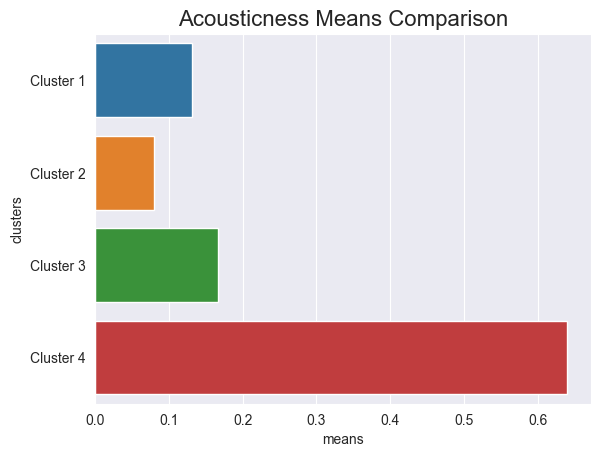

In [151]:
ratings("Acousticness", 100)

## Compare


- Danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

- Energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.

- Loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track. Values typical range between -60 and 0 db.

- Speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.

- Acousticness: A measure from 0.0 to 1.0 of whether the track is acoustic.

- Liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.

- Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

#### High 0.7 - 0.9
#### Moderate 0.4-0.69
#### Low 0.0 - 0.39

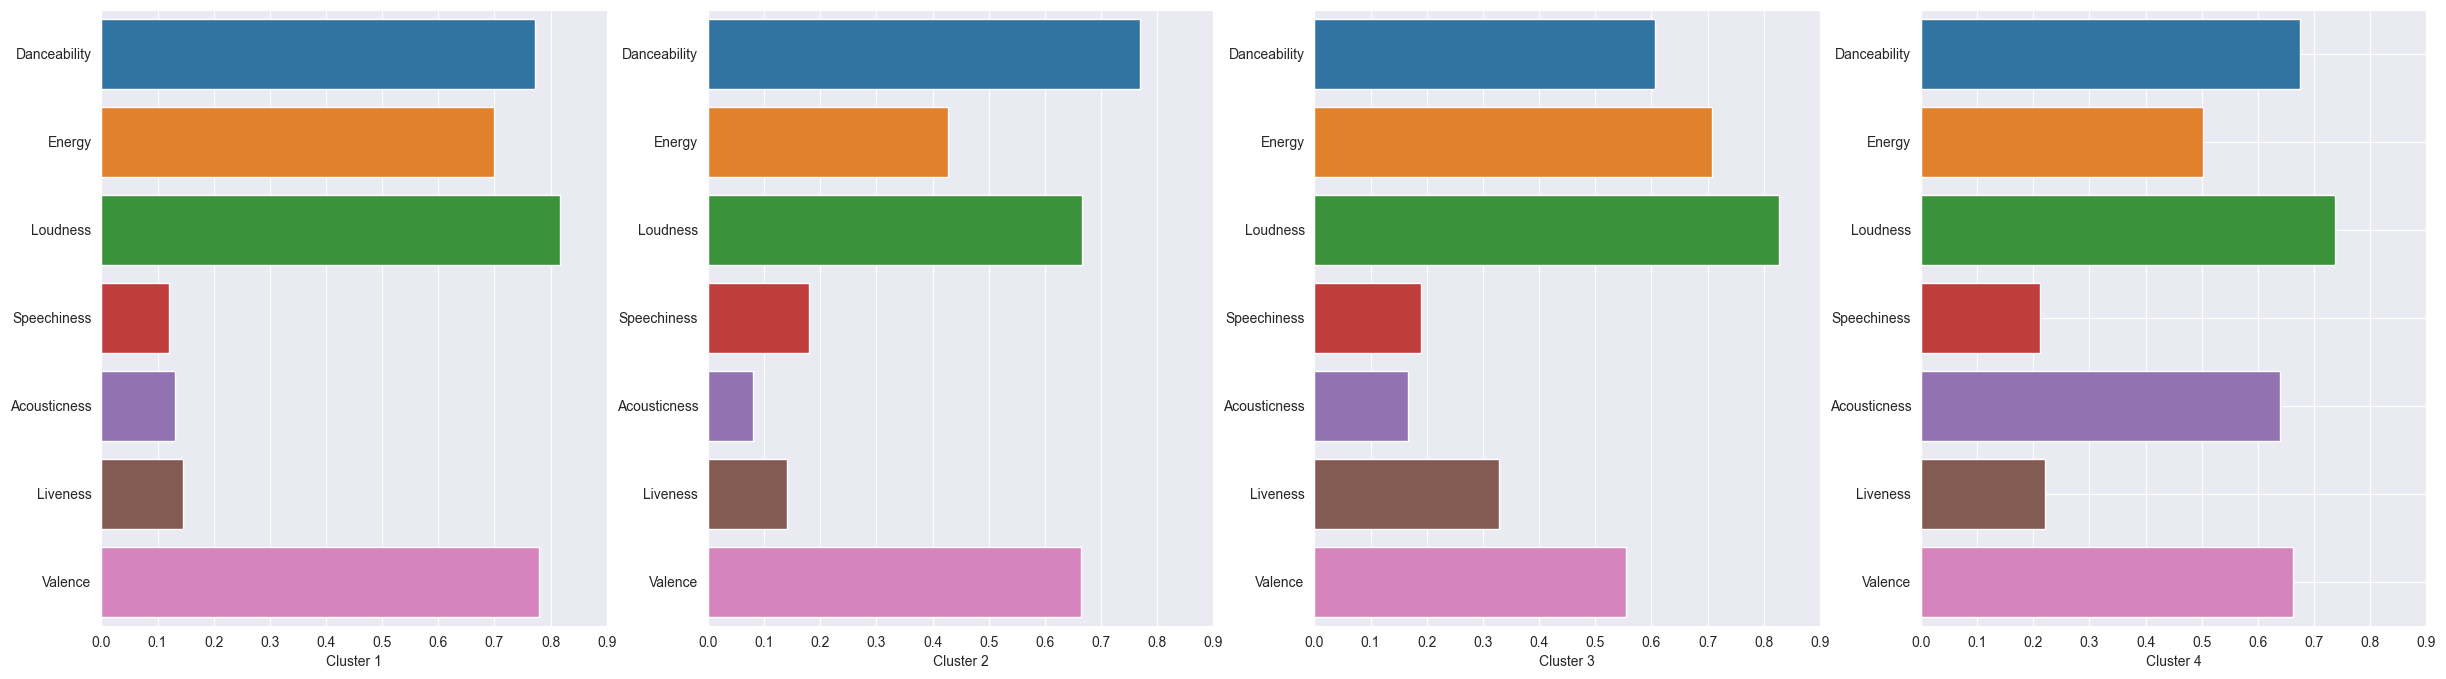

In [154]:
compare(df, 100)

### Cluster 1 Insights

- High Danceability, Loudness & Valence
- Moderate Energy
- Low in Speechiness, Acousticness and Liveness
__________________________________________________
###### ANOVA & Tukey's HSD
- 2nd in Danceability (very close/similar to cluster 2)
- 2nd in Energy (very close/similar to cluster 3)
- 2nd in Loudness (very close/similar to cluster 3)
- 4th in Speechiness
- 3rd in Acousticness (very close/similar to cluster 2 & 3)
- 3rd in Liveness (very close/similar to cluster 2 & 4)
- 1st in Valance

### Cluster 2 Insights

- High in Danceability & Valence
- Moderate Energy & Loudness
- Low in Speechiness, Aousticness and Liveness
__________________________________________________
###### ANOVA & Tukey's HSD
- 1st in Danceability (very close/similar to cluster 1)
- 4th in Energy (very close/similar to cluster 4)
- 4th in Loudness
- 2nd in Speechiness (very close/similar to cluster 3 & 4)
- 4th in Acousticness 
- 4th in Liveness (very close/similar to cluster 1 & 4*)
- 3rd in Valance (very close/similar to cluster 4)
<br>

*Tukey's Only
<br>
**Visual Only

### Cluster 3 Insights

- High in Energy Loudness
- Moderate Danceability & Valence
- Low in Speechiness, Acousticness & Liveness
__________________________________________________
###### ANOVA & Tukey's HSD
- 4th in Danceability
- 1st in Energy (very close/similar to cluster 1)**
- 1st in Loudness
- 2nd in Speechiness (very close/similar to cluster 2 & 4)
- 2nd in Acousticness (very close/similar to cluster 1)
- 1st in Liveness
- 4th in Valance (very close/similar to cluster 4)*
<br>

*Tukey's Only
<br>
**Visual Only

### Cluster 4 Insights

- High in Loudness
- Moderate in Danceability, Energy, Acousticness and Valance
- Low in Speechiness and Liveness
__________________________________________________
###### ANOVA & Tukey's HSD
- 4th in Danceability
- 3rd in Energy (very close/similar to cluster 2)*
- 2nd in Loudness 
- 1st in Speechiness (very close/similar to cluster 3 & 4)
- 1st in Acousticness
- 2nd in Liveness (very close/similar to cluster 1 & 2)*
- 1st in Valance (very close/similar to cluster 2 & 3*)
<br>

*Tukey's Only
<br>
**Visual Only

## Recommenations vs Clusters

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [ ]:
# Connect to the spotify API
client_id = "207d263141ce4bd489a6759df62d55fc"
client_secret = "3678f66a438f48108e0c47045aa13732"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
df2 = pd.read_csv('Files/tracks_classified.csv')

In [ ]:
df2.head()

In [ ]:
df_artist = df2[['track_id','clusters']]

In [ ]:
df_artist.head()

In [ ]:
# Separate each cluster and take a somple from each
cluster_1 = df_artist[df_artist['clusters'] == 0].sample(frac=1, random_state=876).head()['track_id'].values.tolist()
cluster_2 = df_artist[df_artist['clusters'] == 1].sample(frac=1, random_state=876).head()['track_id'].values.tolist()
cluster_3 = df_artist[df_artist['clusters'] == 2].sample(frac=1, random_state=876).head()['track_id'].values.tolist()
cluster_4 = df_artist[df_artist['clusters'] == 3].sample(frac=1, random_state=876).head()['track_id'].values.tolist()

In [ ]:
# Generate recommdations vased on each cluster using the spotify api

# tracks_c1 = sp.recommendations(seed_tracks=cluster_1)['tracks']
# tracks_c2 = sp.recommendations(seed_tracks=cluster_2)['tracks']
# tracks_c3 = sp.recommendations(seed_tracks=cluster_3)['tracks']
# tracks_c4 = sp.recommendations(seed_tracks=cluster_4)['tracks']

In [ ]:
# Create databases for each recommendation

# rec_c1 = recommendations(tracks_c1)
# rec_c2 = recommendations(tracks_c2)
# rec_c3 = recommendations(tracks_c3)
# rec_c4 = recommendations(tracks_c4)

The recommendations from spotify changes every time so the initial recommendations were stored as csv files

In [ ]:
# rec_c1.to_csv('Files/recommendations_cluster1.csv',index=False)
# rec_c2.to_csv('Files/recommendations_cluster2.csv',index=False)
# rec_c3.to_csv('Files/recommendations_cluster3.csv',index=False)
# rec_c4.to_csv('Files/recommendations_cluster4.csv',index=False)

In [ ]:
rec_c1 = pd.read_csv('Files/recommendations_cluster1.csv')
rec_c2 = pd.read_csv('Files/recommendations_cluster2.csv')
rec_c3 = pd.read_csv('Files/recommendations_cluster3.csv')
rec_c4 = pd.read_csv('Files/recommendations_cluster4.csv')

In [ ]:
rec_c1.head()

Loudness was excluded from the features because the nature of that feature is different from the normalized version used to create the clusters. It could be renormalized but it was originally normalized with whole database taken into consideration, and may be different if done on the isolated recommended sample.

In [ ]:
features = ['Danceability', 'Energy', 'Speechiness', 'Acousticness', 'Liveness', 'Valence']

In [ ]:
compare2(cluster1, rec_c1, features)

In [ ]:
compare2(cluster2, rec_c2, features)

In [ ]:
compare2(cluster3, rec_c3, features)

In [ ]:
compare2(cluster4, rec_c4, features)

### Report

As expected, the clusters had more similarities than differences among the different features. Only Cluster 4 had a unique distinction in Acousticness compared to the other clusters.
<br>
Cluster sizes are as follows: 
Cluster 1 -13656 
Cluster 2 -9460
Cluster 3 - 9234
Cluster 4 – 4265
<br>
The next step is to find a way to find songs that would fall within on of these clusters and use those songs to conclude the main objective. This would require data from supervised learning with labelled subgenres to cross examine with the clusters. Unfortunately, there is no such data readily available, so the next best option is to use Spotify’s API to make recommendations based on a sample from each cluster.
Analysing the differences between the clusters and recommendations, two things need to be taken into consideration.
- The method Spotify used by the API to make recommendations
- Are track features sufficient to make judgement on the genre of music.
<br>

Spotify Recommendation
The request made through the Spotify API for song recommendation, does take into consideration the features of the array of tracks submitted. According to the Spotify documentation, Recommendations are generated based on the available information for a given seed entity (tracks submitted for recommendation) and matched against similar artists and tracks. If there is sufficient information about the provided seeds, a list of tracks will be returned together with pool size details. The process it goes through to do the aggregation of the array of features is uncertain, but most if not all of the featured are analysed and cross referenced to generate recommendations. Unfortunately, after using my field knowledge about the characteristics of Jamaican music, I can conclude that the recommendations made by Spotify are not uniform enough to make a conclusive judgment on the subcategories of Jamaican music. The songs recommended have a vast mixture of styles that qualify for all the subsets of Jamaican music so no distinction can be made just by using the recommendation.
<br>

So, are the track features sufficient to determine the subcategories among Jamaican music? Let's take a look at the results. K-means clustering was used to facilitate the unsupervised learning and 4 categories were identified. Visual analysis combined with ANOVA testing and Tukey’s HSD were done on each cluster to determine the differences between and among each cluster. Initially, 6 clusters were hypothesized, but there were more overlaps in similarities between the clusters under these circumstances so, the cluster count was optimized to 4. A sample of each cluster was taken and the Spotify API was used to generate recommendations based on each cluster. These recommendations were too diverse to make any conclusive judgement about the subcategories by ear, so two sample t-tests were done to compare them to their respective clusters.
conclusive judgnement about the subgenre by ear, so two sample t-tests were done to compare them to their respective clusters.
<br>

##### Cluster 1
- Two sample T-test revealed dissimilarities in 2 features (Danceability & Energy), but visual analysis confirms 3 dissimilarities (Danceability, Energy, Speechiness & Acousticness).

##### Cluster 2
- Two sample T-test revealed dissimilarities in 2 features (Energy & Varience), and visual analysis confirms the same, with a significant dissimilarity in Energy.

##### Cluster 3
- Two sample T-test and visual analysis revealed dissimilarities in only 2 features (Danceeability & Liveness), and visual dissimilarities in (Danceability, Energy, Liveness & Valence).

##### Cluster 4
- Two sample T-test revealed dissimilarities in 3 features (Speechiness & Acousticness), but visual analysis confirms dissimilarities in (Danceability, Acousticness, Liveness & Valence) with massive dissimilarity in Acousticness.

<br>
Going trough all the recommendation compared to the respective cluster there weren’t any perfect matches. Out of all the 6 features analysed, on average 4 features were similar to its respective cluster, while 2 features were dissimilar. This represents 66% confidence that the recommendations are similar to the cluster.
<br>

### Conclusion
The objective of this exercise was to determine if there are any quantifiable differences among Jamaican music and determine the subgenres/subcategories using unsupervised learning. Ultimately, the data used from Spotify to make inferences on the categorization of Jamaican music, was not sufficient to make any conclusive judgement. Categories were assumed, but no generalization could be made about its subjective characteristics. What would improve this exercise? If there were more reliable data on release date of tracks, one could assume that it would improve the clustering of data. In addition, if there was a labelled dataset available to cross reference with the clusters, it would be ideal to confirm if the categories generated are useful or accurate. 

